Notebook link:
https://colab.research.google.com/drive/1JXL7vZpDtaS_Pi8iZmtm1CxYJ-TA8Nir?usp=sharing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import ceil, floor
import cv2
import pandas
from scipy import ndimage

#Images

In [2]:
Baboon = cv2.imread('Baboon.bmp', cv2.IMREAD_UNCHANGED)
Barbara = cv2.imread('Barbara.bmp', cv2.IMREAD_UNCHANGED)
F16 = cv2.imread('F16.bmp', cv2.IMREAD_UNCHANGED)
Lena = cv2.imread('Lena.bmp', cv2.IMREAD_GRAYSCALE)

#Utils

In [68]:
def imshow(*args, title=None, figsize=20, to_rgb=True, fontsize=12):
    if isinstance(figsize, int):
        figsize = (figsize, figsize)
    images = args[0] if type(args[0]) is list else list(args)
    if to_rgb:
        images = list(map(lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2RGB), images))
    if title is not None:
        assert len(title) == len(images), "Please provide a title for each image."
    plt.figure(figsize=figsize)
    for i in range(1, len(images)+1):
        plt.subplot(1, len(images), i)
        if title is not None:
            plt.title(title[i-1], fontsize=fontsize)
        if images[i-1].ndim == 2:
            plt.imshow(images[i-1], cmap='gray')
        else:
            plt.imshow(images[i-1])
        plt.axis('off')

In [4]:
def padding(img, p, q):
 my_img = np.zeros((p, q))
 if(np.ndim(img) == 2):
  my_img[0:np.size(img, 0), 0:np.size(img, 1)] = img
 elif(np.ndim(img) == 1):
  my_img[0, 0:np.size(img, 0)] = img
 return my_img

In [13]:
def fourier_transform(image):
    fft = np.fft.fftshift(np.fft.fft2(image))
    magnitude, phase = np.abs(fft), np.angle(fft)
    return magnitude, phase, fft

In [39]:
def fourier_transform_non_shifting(image):
    fft = np.fft.fft2(image)
    magnitude= np.abs(fft)
    return magnitude

In [6]:
def inverse_fourier_transform(magnitude, phase):
    real = np.cos(phase) * magnitude
    imag = np.sin(phase) * magnitude
    fft = real + (1j * imag)
    image = np.fft.ifft2(np.fft.ifftshift(fft))
    image = np.real(image)
    image = image.clip(min=0, max=255).astype('uint8')
    return image

In [7]:
def normalize(image, rmin=0, rmax=255, to_uint=True):
    norm = ((image - image.min()) / (image.max() - image.min())) * (rmax - rmin) + rmin
    if to_uint:
        norm = norm.astype('uint8')
    return norm

In [8]:
def visualize_magnitude(magnitude):
    return normalize(20 * np.log(magnitude))

In [100]:
def DFT(f, h):
  m,n = f.shape
  p=2*m
  q=2*n  
  fp = padding(f,p,q)
  magnitude_F, phase_f, F = fourier_transform(fp)
  hp= padding(h,p,q)
  magnitude_H, phase_H, H = fourier_transform(hp)

  G = F * H
  imshow(visualize_magnitude(magnitude_F + 1), visualize_magnitude(magnitude_H + 1), visualize_magnitude(np.abs(G) + 1), title=['Magnitude Spectrum of F','Magnitude Spectrum of H','Magnitude Spectrum of  G = F * H'],figsize=10) 
  Gp = np.fft.ifftshift(G)
  g = np.fft.ifft2(Gp)
  imshow(f, np.abs(g[0:512 , 0:512]), title=['original_image','Reversed Image'], figsize=10, to_rgb = False)

#4.1. Fourier transform

##4.1.1

In [17]:
filter_a = [[1/16, 2/16, 1/16],
            [2/16, 4/16, 2/16],
            [1/16, 2/16, 1/16]]

filter_b = [[-1, -1, -1],
            [-1, 8, -1],
            [-1, -1, -1]]

filter_c = [[0, -1, 0],
            [-1, 5, -1],
            [0, -1, 0]]                     

###Filter's Fourier transform, and  their magnitude response

In [71]:
mag_filter_C, phase_filter_C, _ = fourier_transform(filter_c)
mag_filter_b, phase_filter_b, _ = fourier_transform(filter_b)
mag_filter_a, phase_filter_a, _ = fourier_transform(filter_a)

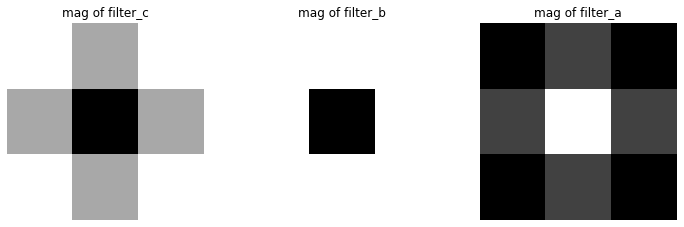

In [72]:
mag_visual_C = visualize_magnitude(mag_filter_C + 1)
mag_visual_b = visualize_magnitude(mag_filter_b + 1)
mag_visual_a = visualize_magnitude(mag_filter_a + 1)
imshow(mag_visual_C , mag_visual_b, mag_visual_a, title=['mag of filter_c','mag of filter_b','mag of filter_a'], to_rgb = False , figsize = 12)

####Result

1- In the coefficients of filter a, it can be seen that as we move away from the center, the effect of the weight on the average decreases, so we are dealing with the **Gaussian** filter, which calculates the weighted average of the image and is a smoothing filter.

2- In the coefficients of filter b, it can be seen that we are dealing with a **Laplacian** filter because the difference between the central pixel and the surrounding pixels becomes zero, and the Laplacian filter is also an edge detection filter.

3- It can also be seen in the c filter coefficients that a Laplacian filter is combined with the original image (unsharp masking), that is, the edges are enhanced and added to the image again, so we are dealing with an **edge enhancement** filter.

By examining the spectrum of the edges, we can see that if the values are large in the center of the filter and the values decrease as we move away from the center, we are dealing with a smoothing filter. If the spectrum of the filter has a zero value in the center and large values in the values far from the center, we are dealing with an edge detector filter. And if the spectrum in the values far from the center has a larger value and in the center a smaller value than the surrounding, we are faced with an edge enhancement filter.

####whether filters are separable

A separable filter is a filter whose rows are multiples of each other, so the only filter that has this property is filter a.

This filter can be converted into two row and column matrices. When applying it to the image, we must first pad the row matrix to the number of columns of the original image, and after moving the filter to the frequency domain, multiply the filter in each row of the image.

Then we also pad the column matrix and move to the frequency domain in a similar way and multiply the image columns.

#####Smoothing 

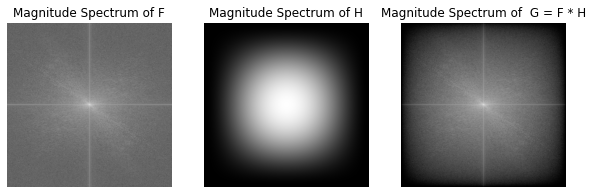

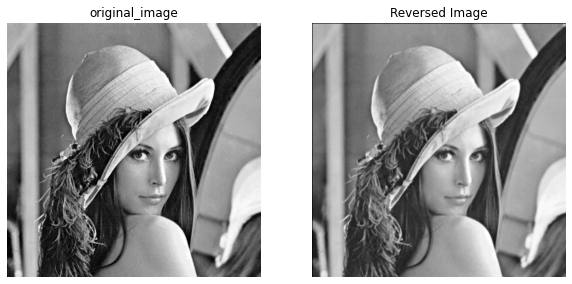

In [101]:
DFT(Lena, filter_a)

#####Edge detection 

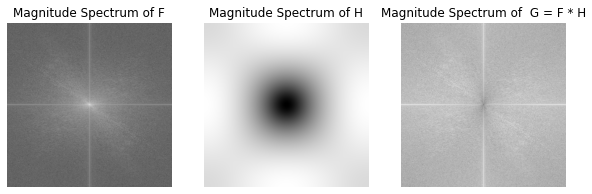

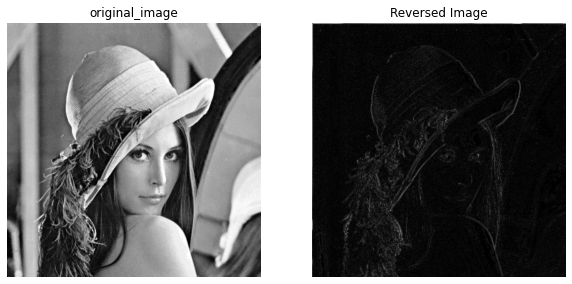

In [102]:
DFT(Lena, filter_b)

#####Edge enhancement 

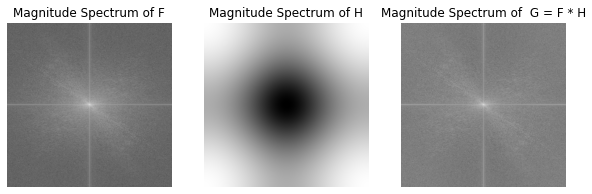

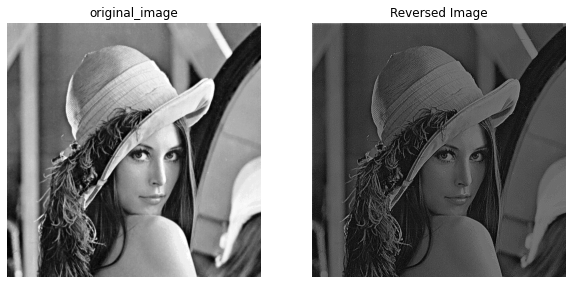

In [103]:
DFT(Lena, filter_c)

##4.1.2

In [56]:
def with_shifting(img):
  mag, phase, f = fourier_transform(img)

  mag_normal = normalize(mag)
  mag_visual = visualize_magnitude(mag + 1)

  titles = ['Image', 'mag without log', 'log(magnitude)']
  imshow(img, mag_normal, mag_visual, title=titles, figsize=10)

In [57]:
def without_shifting(img):
  mag = fourier_transform_non_shifting(img)

  mag_normal = normalize(mag)
  mag_visual = visualize_magnitude(mag + 1)

  titles = ['Image', 'mag without log', 'log(magnitude)']
  imshow(img, mag_normal, mag_visual, title=titles, figsize=10)

###Lena

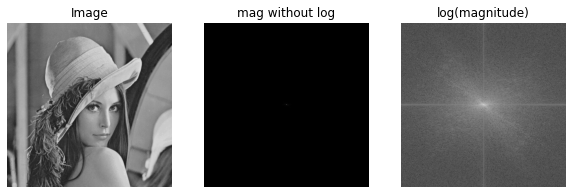

In [78]:
with_shifting(Lena)

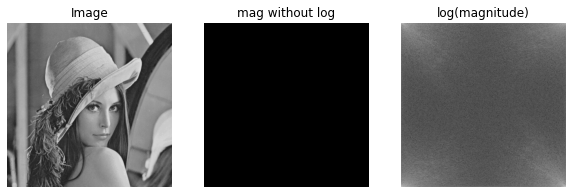

In [79]:
without_shifting(Lena)

###Barbara

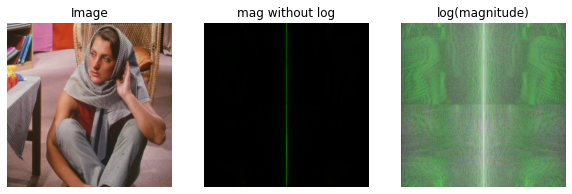

In [80]:
with_shifting(Barbara)

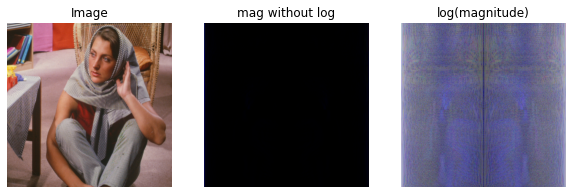

In [81]:
without_shifting(Barbara)

###F16

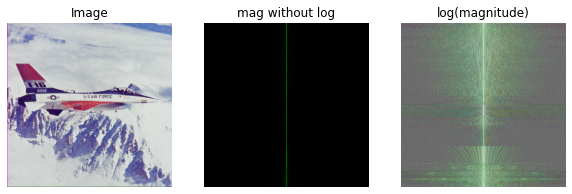

In [82]:
with_shifting(F16)

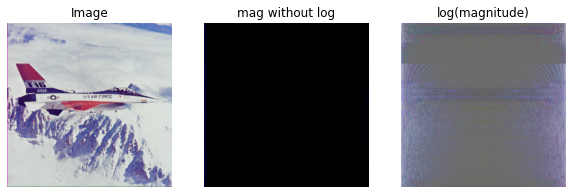

In [83]:
without_shifting(F16)

###Baboon

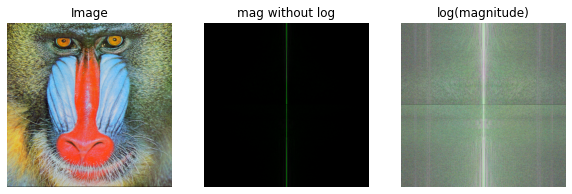

In [85]:
with_shifting(Baboon)

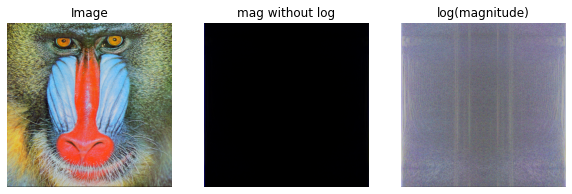

In [86]:
without_shifting(Baboon)

###Result

If we display the spectrum of the image **without shifting**, the main information of the image will be placed in the upper left corner of the image, and because the image is repeated periodically, as a result, this point can also be seen in the other three corners of the image. If we shift the image, the main information and large coefficients will be moved to the center of the image

If we **don't use the logarithm**, by using this logarithmic function, we can bring the values that have very high dispersion coefficients (for example, low frequencies) closer to each other, thus making the information better displayed for us when displaying the spectrum.

####which frequency range the DFT coefficients have large magnitudes

Large coefficients are located in low frequencies, which is the reason that each of the frequencies in the images add information to the image.
Low frequencies add information related to the generality of images and main information to the image, and higher frequencies include information related to image details and edges and noises. As a result, in relation to high frequencies, whose coefficients are much smaller, there are larger coefficients in low frequencies.

##4.2.1

First, we need to take the filter and the image to the size of 256 + 11 x 256 + 11 using zero padding, and as a result, the output image is also 267 x 267 in size.

If we assume that the size of the filter and the size of the image are equal, and the size of the output image from the convolution and the output image from the frequency domain is equal to 256 x 256, the sum of the filter size and the image size should be equal to 256 x 256. It has been said that the size of the image and the filter are equal to each other, so the size of both of them must be 128 x 128 (128 = n = m) so that the said conditions are met.